In [11]:
# !pip install -U huggingface_hub datasets qdrant-client seaborn

In [16]:
import os
import time
import json

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from datasets import load_dataset
from qdrant_client import QdrantClient, models
from qdrant_client.models import PointStruct

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/nirantk/.cache/huggingface/token
Login successful


In [18]:
dataset = load_dataset("nirantk/dbpedia-entities-google-palm-gemini-embedding-001-100K", streaming=False, split='train')
dataset

Dataset({
    features: ['_id', 'title', 'text', 'embedding'],
    num_rows: 100000
})

In [4]:
client = QdrantClient(
    url="https://a4197291-1236-40e0-bf18-18e8843a05a2.us-east4-0.gcp.cloud.qdrant.io:6333", 
    api_key=os.getenv("QDRANT_API_KEY"),
    timeout=100,
    prefer_grpc=True
)

# Setting up a Collection with Binary Quantization

In [5]:
collection_name = "gemini-embedding-001"

In [6]:
# client.recreate_collection(
#     collection_name=f"{collection_name}",
#     vectors_config=models.VectorParams(
#         size=768,
#         distance=models.Distance.COSINE,
#         on_disk=True,
#     ),
#     optimizers_config=models.OptimizersConfigDiff(
#         default_segment_number=5,
#         indexing_threshold=0,
#     ),
#     quantization_config=models.BinaryQuantization(
#         binary=models.BinaryQuantizationConfig(always_ram=True),
#     ),
#     shard_number=2,
# )

In [19]:
collection_info = client.get_collection(collection_name=collection_name)

points=[
        {
            "id": i,
            "vector": embedding,
            "payload": {"text": data["text"], "title": data["title"]}
        }
        for i, (embedding, data) in enumerate(zip(dataset["embedding"], dataset))
    ]
points = [PointStruct(**point) for point in points]

if collection_info.vectors_count == 0:
    print("Collection is empty. Begin indexing.")
    bs = 100 # Batch size    
    for i in tqdm(range(0, len(points), bs)):
        slice_points = points[i:i+bs]  # Create a slice of bs points
        client.upsert(
            collection_name=collection_name,
            points=slice_points
        )
    client.update_collection(
        collection_name=f"{collection_name}",
        optimizer_config=models.OptimizersConfigDiff(
            indexing_threshold=20000
        )
    )

In [20]:
collection_info = client.get_collection(collection_name=collection_name)
collection_info.vectors_count

100000

In [49]:
client.search(
    collection_name=f"{collection_name}",
    query_vector=points[32].vector,
    search_params=models.SearchParams(
        quantization=models.QuantizationSearchParams(
            ignore=False,
            rescore=False,
            oversampling=2.0,
        ),
        exact=True,
    ),
    limit=5
)

[ScoredPoint(id=32, version=0, score=1.0, payload={'text': 'Sobrassada (Catalan pronunciation: [soβɾəˈsaðə]; Spanish: sobrasada) is a raw, cured sausage from the Balearic Islands made with ground pork, paprika and salt and other spices. Sobrassada, along with botifarró are traditional Balearic sausage meat products prepared in the laborious but festive rites that still mark the autumn and winter pig slaughter known as a matança (in Spanish, matanza) in Majorca and Eivissa.', 'title': 'Sobrassada'}, vector=None, shard_key=None),
 ScoredPoint(id=78000, version=780, score=0.7025156617164612, payload={'text': 'Tamborrada of Donostia (in Basque Donostiako Danborrada) is a celebratory drum festival held every year on January 20 in the city of San Sebastián, Spain. At midnight, in the Konstituzio Plaza in the "Alde Zaharra/Parte Vieja" (Old Town), the mayor raises the flag of San Sebastián. The festival lasts for 24 hours. Participants, dressed as cooks and soldiers, march in companies across

In [52]:
ds = dataset.train_test_split(test_size=0.1, shuffle=True, seed=37)['test']

In [24]:
oversampling_range = np.arange(1.0, 3.0, 0.5)
rescore_range = [True, False]

def parameterized_search(
        point, 
        oversampling: float, 
        rescore: bool, 
        exact: bool, 
        collection_name: str, 
        ignore: bool = False,
        limit: int = 10
    ):
    return client.search(
        collection_name=collection_name,
        query_vector=point.vector,
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(
                ignore=ignore, # Whether Qdrant should ignore the quantization index
                rescore=rescore,
                oversampling=oversampling,
            ),
            exact=exact,     
        ),
        limit=limit
    )

results = []
with open("results.json", "w") as f:
    for element in tqdm(points[:1000]):
        # print(element.payload["text"])
        # print("Oversampling")
        for oversampling in oversampling_range:
            for rescore in rescore_range:
                start = time.time()
                binary_quantization_results = parameterized_search(element, oversampling=oversampling, rescore=rescore, exact=False, collection_name=collection_name)
                end = time.time()
                id = element.id
                for k in [1, 3, 5, 10]:
                    selected_results = binary_quantization_results[:k]
                    ids = [result.id for result in selected_results]
                    present = id in ids
                    f.write(json.dumps({
                        "query_id": id,
                        "oversampling": oversampling,
                        "rescore": rescore,
                        "k": k,
                        "present": present,
                        "score": selected_results[ids.index(id)].score if present else None,
                        "turnaround_time": end - start
                    }))
                    f.write("\n")

                    results.append({
                        "id": id,
                        "oversampling": oversampling,
                        "rescore": rescore,
                        "k": k,
                        "present": present,
                        "score": selected_results[ids.index(id)].score,
                        "turnaround_time": end - start
                    })
                

 13%|█▎        | 132/1000 [05:06<33:33,  2.32s/it]

<Axes: xlabel='oversampling,rescore'>

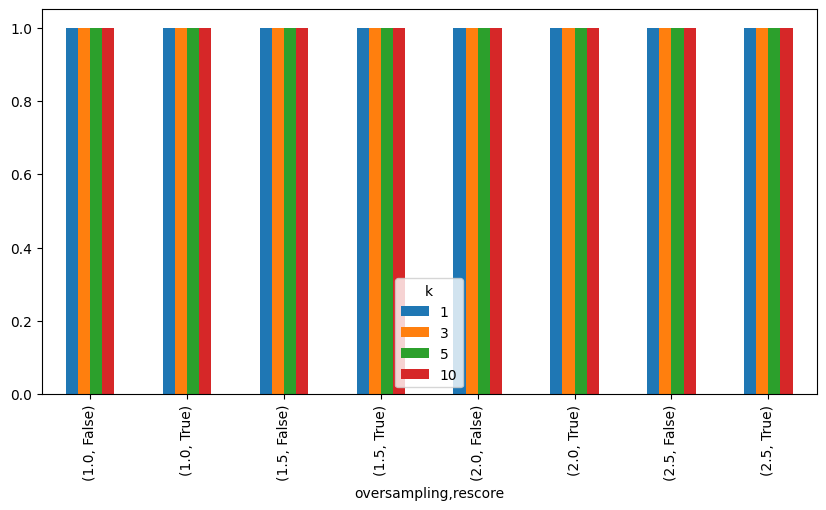

In [79]:
df = pd.DataFrame(results)
df[df['score'] > 0.9].groupby(['oversampling', 'rescore', 'k']).mean()['present'].unstack().plot(kind='bar', figsize=(10, 5))
# sum(df.present) / len(df)